In [1]:
import numpy as np
from matplotlib.pyplot import *
from skimage import filters, segmentation, measure, morphology, feature
import matplotlib.colors as mcolors
from scipy import ndimage as ndi

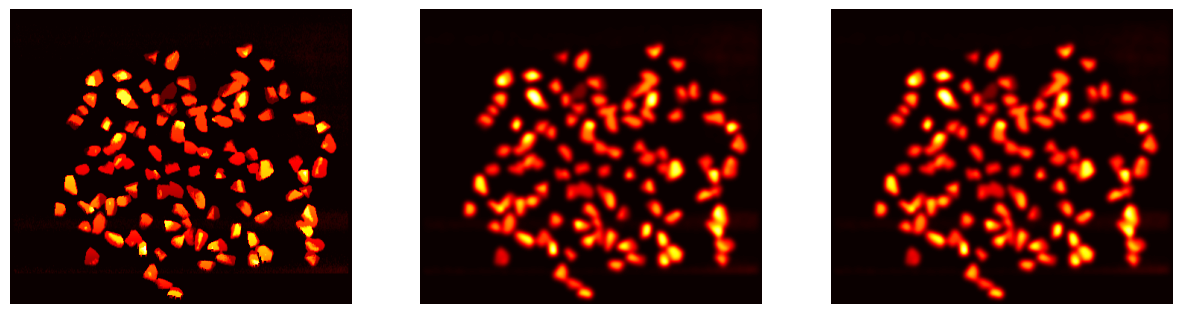

In [2]:
scan = np.load('../data/12_sample1.npy')
s1_scan = filters.gaussian(scan, sigma=3) # smoothing
s2_scan = filters.median(s1_scan, footprint=np.ones((3,)*2)) # smoothing

fig, axs = subplots(nrows=1, ncols=3, figsize=(15,6))
axs[0].imshow(scan, cmap="hot")
axs[0].set_axis_off()
axs[0].set_aspect('equal')

axs[1].imshow(s1_scan, cmap="hot")
axs[1].set_axis_off()
axs[1].set_aspect('equal')

axs[2].imshow(s2_scan, cmap="hot")
axs[2].set_axis_off()
axs[2].set_aspect('equal')

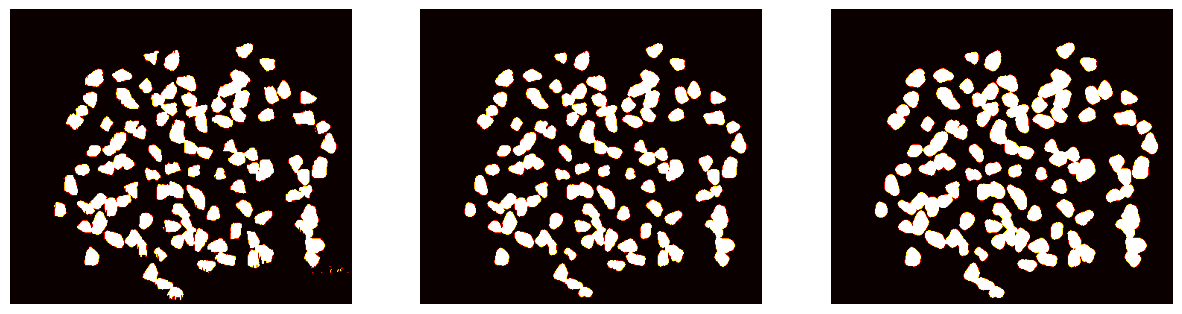

In [3]:
binary = scan > filters.threshold_li(s2_scan)
s1_binary = morphology.binary_opening(binary, morphology.disk(3))
s2_binary = morphology.binary_dilation(s1_binary)

fig, axs = subplots(nrows=1, ncols=3, figsize=(15,6))
axs[0].imshow(binary, cmap="hot")
axs[0].set_axis_off()
axs[0].set_aspect('equal')

axs[1].imshow(s1_binary, cmap="hot")
axs[1].set_axis_off()
axs[1].set_aspect('equal')

axs[2].imshow(s2_binary, cmap="hot")
axs[2].set_axis_off()
axs[2].set_aspect('equal')

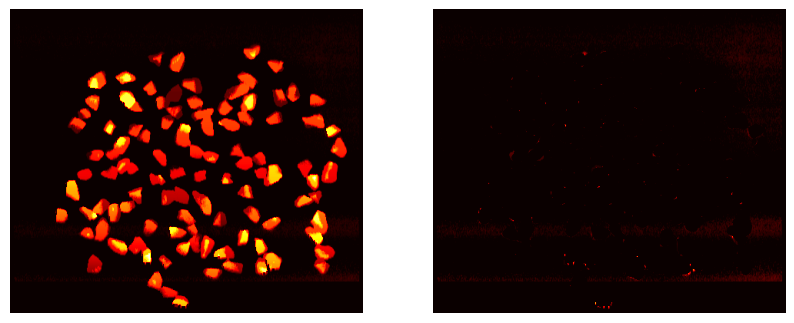

In [4]:
fig, axs = subplots(nrows=1, ncols=2, figsize=(10,6))
axs[0].imshow(scan, cmap="hot")
axs[0].set_axis_off()
axs[0].set_aspect('equal')

axs[1].imshow(scan * (1-s2_binary), cmap="hot")
axs[1].set_axis_off()
axs[1].set_aspect('equal')

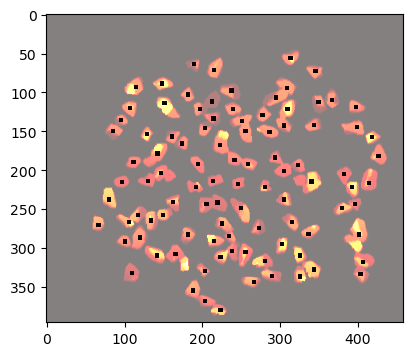

In [5]:
rocks = (scan * s2_binary)
distance = ndi.distance_transform_edt(rocks)
coords = feature.peak_local_max(distance, min_distance=8)
mask = np.zeros_like(distance, dtype=bool)
mask[tuple(coords.T)] = True
markers, _ = ndi.label(mask)
labels = segmentation.watershed(-distance, markers, mask=s2_binary)

fig, ax = subplots(nrows=1, ncols=1, figsize=(12,4))
ax.imshow(rocks, cmap='hot', alpha=0.5)
dilated_mask = morphology.binary_dilation(mask, footprint=np.ones((7,)*2))
ax.imshow(np.ma.masked_where(dilated_mask == 0, dilated_mask), cmap='hot', alpha=1)

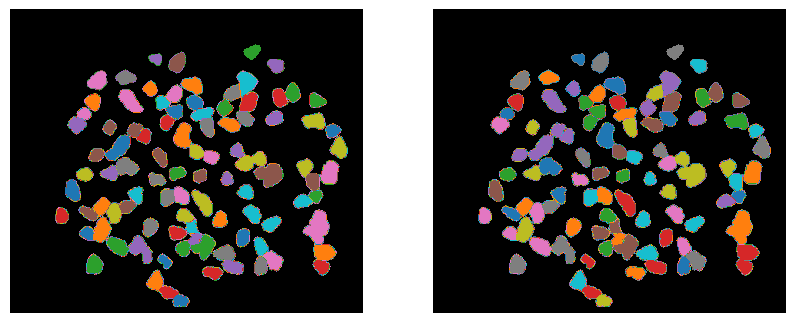

In [6]:
n_repeats = 2
fig, axs = subplots(nrows=1, ncols=n_repeats, figsize=(5*n_repeats,4))
for i in range(n_repeats):
    cmap = cm.get_cmap('tab10')(np.linspace(0, 1, len(np.unique(labels))))
    cmap = np.random.permutation(cmap)
    cmap[0,:-1] = 0
    cmap = mcolors.ListedColormap(cmap)
    axs[i].imshow(labels, cmap=cmap)
    axs[i].set_axis_off()
    axs[i].set_aspect('equal')

In [69]:
def intensity_median(regionmask, intensity):
    return np.median(intensity[regionmask])

def intensity_std(regionmask, intensity):
    return np.std(intensity[regionmask])

def gradient_max_intensity(regionmask, intensity):
    edges = filters.sobel(intensity * regionmask)
    idx_max = np.unravel_index(np.argmax(intensity * regionmask), intensity.shape)
    return edges[idx_max]

def mean_gradient(regionmask, intensity):
    edges = filters.sobel(intensity)
    return np.mean(edges[regionmask])

def std_gradient(regionmask, intensity):
    edges = filters.sobel(intensity)
    return np.std(edges[regionmask])

In [70]:
regions = measure.regionprops(labels, scan, extra_properties=(intensity_median, intensity_std, gradient_max_intensity,mean_gradient,std_gradient))